# Tutorial 8: Deep Energy-Based Generative Models

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Under%20development&color=red)

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial8/Deep_Energy_Models.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial8/Deep_Energy_Models.ipynb)

**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/tutorial8)
[![GoogleDrive](https://img.shields.io/static/v1.svg?logo=google-drive&logoColor=yellow&label=GDrive&message=Download&color=yellow)](https://drive.google.com/drive/folders/11ZI7x2sfCNtaZUNpe4v08YXWN870spXs?usp=sharing)

In this tutorial, we will look at energy-based deep learning models, and focus on their application as generative models. Energy models have been a popular tool before the huge deep learning hype around 2012 hit. However, in recent years, energy-based models have gained increasing attention because of improved training methods and tricks being proposed. Although they are still in a research stage, they have shown to outperform strong Generative Adversarial Networks (Lecture/Tutorial 10) in certain cases which have been the state of the art of generating images ([blog post] about strong energy-based models, [blog post](https://medium.com/syncedreview/nvidia-open-sources-hyper-realistic-face-generator-stylegan-f346e1a73826) about power of GANs). Hence, it is important to be aware of energy-based models, and as the theory can be abstract sometimes, we will show the idea of energy-based models with a lot of examples.

First, let's import our standard libraries below.

In [1]:
USE_NOTEBOOK = False

## Standard libraries
import os
import json
import math
import numpy as np 
import random

## Imports for plotting
import matplotlib.pyplot as plt
if USE_NOTEBOOK:
    # %matplotlib inline 
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('svg', 'pdf') # For export
    from matplotlib.colors import to_rgb
    import matplotlib
    matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial8"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

We also have pre-trained models that we download below.

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial8/"
# Files to download
pretrained_files = []

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Energy Models

In the first part of the tutorial, we will review the theory of the energy-based models. While most of the previous models had the goal of classification or regression, energy-based models are motivated from a different perspective: probability modeling. Given a dataset with a lot of elements, we want to estimate the probability distribution over the whole data space. As an example, if we model images from CIFAR10, our goal would be to have a probability distribution over all possible images of size $32\times32\times3$ where those images have a high likelihood that looks realistic and are one of the 10 CIFAR classes. Simple methods like interpolation etc. don't work because images are extremely high-dimensional (especially for large HD images). Hence, we turn to deep learning methods that have performed well on complex data.

However, how do we predict a probability distribution $p(\mathbf{x})$ over so many dimensions using a simple neural network? The problem is that we cannot just predict a score between 0 and 1, because a probability distribution over data needs to fulfill two properties:

1. The probability distribution needs to assign any possible value of $\mathbf{x}$ a non-negative value: $p(\mathbf{x}) \geq 0$.
2. The probability density must sum/integrate to 1 over **all** possible inputs: $\int_{\mathbf{x}} p(\mathbf{x}) d\mathbf{x} = 1$. 

Luckily, there are actually many approaches for this, and one of them are energy-based models. The fundamental idea of energy-based models is that you can turn any function that predicts values larger than zero into a probability distribution by dviding by its volume. Imagine we have a neural network, which has as output a single neuron, like in regression. We can call this network $E_{\theta}(\mathbf{x})$, where $\theta$ are our parameters of the network, and $\mathbf{x}$ the input data (e.g. an image). The output of $E_{\theta}$ is a scalar value between $-\infty$ and $\infty$. Now, we can use basic probability theory to *normalize* the scores of all possible inputs:

$$
q_{\theta}(\mathbf{x}) = \frac{\exp\left(-E_{\theta}(\mathbf{x})\right)}{Z_{\theta}} \hspace{5mm}\text{where}\hspace{5mm}
Z_{\theta} = \begin{cases}
    \int_{\mathbf{x}}\exp\left(-E_{\theta}(\mathbf{x})\right) d\mathbf{x} & \text{if }x\text{ is continuous}\\
    \sum_{\mathbf{x}}\exp\left(-E_{\theta}(\mathbf{x})\right) d\mathbf{x} & \text{if }x\text{ is discrete}
\end{cases}
$$

The $\exp$-function ensures that we assign a probability greater than zero to any possible input. We use a negative sign in front of $E$ because we call $E_{\theta}$ to be the energy function: points with high likelihood have low energy, and vice versa. $Z_{\theta}$ is our normalization terms which ensures that the density integrates/sums to 1. We can show this by integrating over $q_{\theta}(\mathbf{x})$:

$$
\int_{\mathbf{x}}q_{\theta}(\mathbf{x})d\mathbf{x} = 
\int_{\mathbf{x}}\frac{\exp\left(-E_{\theta}(\mathbf{x})\right)}{\int_{\mathbf{\tilde{x}}}\exp\left(-E_{\theta}(\mathbf{\tilde{x}})\right) d\mathbf{\tilde{x}}}d\mathbf{x} =
\frac{\int_{\mathbf{x}}\exp\left(-E_{\theta}(\mathbf{x})\right)d\mathbf{x}}{\int_{\mathbf{\tilde{x}}}\exp\left(-E_{\theta}(\mathbf{\tilde{x}})\right) d\mathbf{\tilde{x}}} = 1
$$

Note that we call the probability distribution $q_{\theta}(\mathbf{x})$ because this is the learned distribution by the model, and is trained to be as close as possible to the *true*, unknown distribution $p(\mathbf{x})$. 

The main benefit of this formulation of the probability distribution is its great flexibility as we can choose $E_{\theta}$ in what ever way we like, without any constraints. Nevertheless, when looking at aboves equation, we can see a fundamental issue: How do we calculate $Z_{\theta}$? There is no chance that we can calculate $Z_{\theta}$ analytically for high-dimensional input and/or larger neural networks, but the task requires us to know $Z_{\theta}$. Although we can't determine the exact likelihood of a point, there exist methods with which we can train 

### Contrastive Divergence

$$
\begin{split}
    \nabla_{\theta}\mathcal{L}_{\text{MLE}}(\mathbf{\theta};p) & = -\mathbb{E}_{p(\mathbf{x})}\left[\nabla_{\theta}\log q_{\theta}(\mathbf{x})\right]\\[5pt]
    & = \mathbb{E}_{p(\mathbf{x})}\left[\nabla_{\theta}E_{\theta}(\mathbf{x})\right] - \mathbb{E}_{q_{\theta}(\mathbf{x})}\left[\nabla_{\theta}E_{\theta}(\mathbf{x})\right]
\end{split}
$$

### Sampling from Energy Based Models

Iterative approach: Markov Chain Monte Carlo

### Applications of Energy-based models beyond generation

Modeling the probability distribution for sampling new data is not the only application of energy-based models. Any application which requires us to compare two elements is much simpler to learn because we just need to go for the higher energy. Couple of examples are shown below (figure credit - [Stefano Ermon and Aditya Grover](https://deepgenerativemodels.github.io/assets/slides/cs236_lecture11.pdf)). A classification setup like object recognition or sequence labeling can be considered as a energy-based task as we just need to find the $Y$ input that minimizes the output $E(X,Y)$ (hence maximizes probability). Similarly, a popular application of energy-based models is denoising of images. Given an image $X$ with a lot of noise, we try to minimize the energy by finding the true input image $Y$. 

<center width="100%"><img src="energy_models_application.svg" width="600px"></center>

Nonetheless, we will focus on generative modeling here as in the next couple of lectures, we will discuss more generative deep learning approaches.

## Toy example: Mixture of Gaussian

## Image generation

* Based on [blog](https://openai.com/blog/energy-based-models/) and [paper](https://arxiv.org/abs/1903.08689)
* Spectral Normalization for discriminators in GANs [paper](https://arxiv.org/pdf/1802.05957.pdf)

In [2]:
# Transformations applied on each image => make them a tensor and normalize
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True,  drop_last=True,  num_workers=4, pin_memory=True)
test_loader  = data.DataLoader(test_set,  batch_size=256, shuffle=False, drop_last=False, num_workers=4)

In [8]:
class Sampler:

    def __init__(self, model, img_shape, sample_size, max_len=8192):
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [torch.rand((1,)+img_shape) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)

        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        self.model.train()
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True
        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)
        imgs_per_step = []
        for _ in range(steps):
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03)

            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)
            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())
        
        for p in model.parameters():
            p.requires_grad = True

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

In [3]:
class Swish(nn.Module):
    
    def forward(self, x):
        return x * torch.sigmoid(x)

act_fn_by_name = {
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU,
    "relu": nn.ReLU,
    "swish": Swish
}

In [4]:
def conv2d(*args, **kwargs):
    return nn.utils.spectral_norm(nn.Conv2d(*args, **kwargs))

In [5]:
class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, act_fn_name="swish"):
        super().__init__()
        act_fn = act_fn_by_name.get(act_fn_name, Swish)
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2
        self.cnn_layers = nn.Sequential(
                conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4), # [16x16]
                act_fn(),
                conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                act_fn(),
                conv2d(c_hid2, c_hid3, kernel_size=3, stride=1, padding=1),
                act_fn(),
                conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                act_fn(),
                conv2d(c_hid3, c_hid3, kernel_size=3, stride=1, padding=1),
                nn.AvgPool2d(kernel_size=4),
                nn.Flatten(),
                nn.Linear(c_hid3, c_hid3),
                act_fn(),
                nn.Linear(c_hid3, out_dim)
        )


    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

In [6]:
class CNNModel2(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, act_fn_name="swish"):
        super().__init__()
        act_fn = act_fn_by_name.get(act_fn_name, Swish)
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2
        self.cnn_layers = nn.Sequential(
                conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4), # [16x16] - Larger padding to get 32x32 image
                act_fn(),
                conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                act_fn(),
                conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                act_fn(),
                conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [2x2]
                act_fn(),
                nn.Flatten(),
                nn.Linear(c_hid3*4, c_hid3),
                act_fn(),
                nn.Linear(c_hid3, out_dim)
        )


    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

In [7]:
class ResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in

        # Network representing F
        self.net = nn.Sequential(
            act_fn(),
            conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2),
            act_fn(),
            conv2d(c_out, c_out, kernel_size=3, padding=1)
        )

        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        if not subsample:
            self.downsample = None
        else:
            down_samp_layers = []
            if c_in != c_out:
                down_samp_layers += [act_fn(), conv2d(c_in, c_out, kernel_size=1, stride=1, padding=0)]
            down_samp_layers += [nn.AvgPool2d(kernel_size=2, stride=2, padding=0)]
            self.downsample = nn.Sequential(*down_samp_layers)
        self.act_fn = act_fn()


    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        return out
    

class ResNetModel(nn.Module):
    
    def __init__(self, hidden_features=64, out_dim=1, act_fn_name="swish"):
        super().__init__()
        act_fn = act_fn_by_name.get(act_fn_name, Swish)
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4), # [16x16] - Larger padding to get 32x32 image
            ResNetBlock(c_hid1, act_fn=act_fn, subsample=True, c_out=c_hid1), # [8x8]
            ResNetBlock(c_hid1, act_fn=act_fn, subsample=False),
            ResNetBlock(c_hid1, act_fn=act_fn, subsample=True, c_out=c_hid2), # [4x4]
            ResNetBlock(c_hid2, act_fn=act_fn, subsample=False),
            ResNetBlock(c_hid2, act_fn=act_fn, subsample=True, c_out=c_hid3), # [2x2]
            ResNetBlock(c_hid3, act_fn=act_fn, subsample=False),
            nn.Flatten(),
            act_fn(),
            nn.utils.spectral_norm(nn.Linear(c_hid3*4, out_dim))
        )
        
    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

### Lightning Module

In [20]:
class DeepEnergyModel(pl.LightningModule):
    
    def __init__(self, img_shape, batch_size, alpha=0.1, model_name="CNNModel", lr=1e-4, beta1=0.9, **CNN_args):
        super().__init__()
        self.save_hyperparameters()
        
        if model_name == "CNNModel":
            self.cnn = CNNModel(**CNN_args)
        elif model_name == "CNNModel2":
            self.cnn = CNNModel2(**CNN_args)
        elif model_name == "ResNet":
            self.cnn = ResNetModel(**CNN_args)
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size)
        
        self.alpha = alpha
        self.example_input_array = torch.zeros(1, *img_shape)
        
    def forward(self, x):
        z = self.cnn(x)
        return z
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)
        
        fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)
        
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)
        
        reg_loss = self.alpha * (real_out ** 2 + fake_out ** 2).mean()
        diff_loss = fake_out.mean() - real_out.mean()
        
        loss = reg_loss + diff_loss
        
        self.log('loss', loss)
        self.log('loss_regularization', reg_loss)
        self.log('loss_difference', diff_loss)
        self.log('metrics_avg_real', real_out.mean())
        self.log('metrics_avg_fake', fake_out.mean())
        return loss
    
    def validation_step(self, batch, batch_idx):
        real_imgs, _ = batch
        fake_imgs = torch.rand_like(real_imgs) * 2 - 1
        
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)
        
        diff = real_out.mean() - fake_out.mean()
        self.log('val_diff', diff)
        self.log('val_fake_out', fake_out.mean())
        self.log('val_real_out', real_out.mean())

### Callbacks

In [21]:
class GenerateCallback(pl.Callback):

    def __init__(self, batch_size=8, vis_steps=8, num_steps=256, every_n_epochs=1):
        super().__init__()
        self.batch_size = batch_size # Number of images to generate
        self.vis_steps = vis_steps # Number of steps within generation to visualize
        self.num_steps = num_steps # Number of steps to take during generation
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            imgs_per_step = self.generate_imgs(pl_module)
            # Plot and add to tensorboard
            for i in range(imgs_per_step.shape[1]):
                step_size = self.num_steps // self.vis_steps
                imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
                grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1,1))
                trainer.logger.experiment.add_image("generation_%i" % i, grid, global_step=trainer.current_epoch)
                
    def generate_imgs(self, pl_module):
        pl_module.eval()
        start_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
        start_imgs = start_imgs * 2 - 1
        imgs_per_step = Sampler.generate_samples(pl_module.cnn, start_imgs, steps=self.num_steps, step_size=10, return_img_per_step=True)
        pl_module.train()
        return imgs_per_step

In [22]:
class SamplerCallback(pl.Callback):
    
    def __init__(self, num_imgs=32, every_n_epochs=1):
        super().__init__()
        self.num_imgs = num_imgs
        self.every_n_epochs = every_n_epochs
        
    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            exmp_imgs = torch.cat(random.choices(pl_module.sampler.examples, k=self.num_imgs), dim=0)
            grid = torchvision.utils.make_grid(exmp_imgs, nrow=4, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("sampler", grid, global_step=trainer.current_epoch)

In [23]:
class OutlierCallback(pl.Callback):
    
    def __init__(self, batch_size=1024):
        super().__init__()
        self.batch_size = batch_size
    
    def on_epoch_end(self, trainer, pl_module):
        with torch.no_grad():
            pl_module.eval()
            rand_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
            rand_imgs = rand_imgs * 2 - 1.0
            rand_out = pl_module.cnn(rand_imgs).mean()
            pl_module.train()
        
        trainer.logger.experiment.add_scalar("rand_out", rand_out, global_step=trainer.current_epoch)

### Training

In [24]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "MNIST"),
                         checkpoint_callback=ModelCheckpoint(save_weights_only=True, mode="max", monitor='val_diff'),
                         gpus=1,
                         max_epochs=60,
                         gradient_clip_val=0.1,
                         callbacks=[GenerateCallback(every_n_epochs=5),
                                    SamplerCallback(every_n_epochs=5),
                                    OutlierCallback(),
                                    LearningRateMonitor("epoch")
                                   ],
                        progress_bar_refresh_rate=1 if USE_NOTEBOOK else 0)
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "MNIST.ckpt")
    if os.path.isfile(pretrained_filename):
        model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = DeepEnergyModel(**kwargs)
        trainer.fit(model, train_loader, test_loader)
    # No testing as we are more interested in other properties
    return model

In [25]:
for lr in [1e-4]:
    for beta1 in [0.0]:
        for model_name in ["ResNet", "CNNModel2"]: # , 
            model = train_model(img_shape=(1,28,28), 
                                batch_size=train_loader.batch_size,
                                lr=lr,
                                beta1=beta1,
                                model_name=model_name)

GPU available: True, used: True
I1115 14:38:16.951970 139891723200320 distributed.py:49] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I1115 14:38:16.954170 139891723200320 distributed.py:49] TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
I1115 14:38:16.955670 139891723200320 accelerator_connector.py:385] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type      | Params | In sizes       | Out sizes
----------------------------------------------------------------
0 | cnn  | CNNModel2 | 76 K   | [1, 1, 28, 28] | [1]      
I1115 14:38:16.995291 139891723200320 lightning.py:1290] 
  | Name | Type      | Params | In sizes       | Out sizes
----------------------------------------------------------------
0 | cnn  | CNNModel2 | 76 K   | [1, 1, 28, 28] | [1]      


/home/phillip/anaconda3/envs/nlp1/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


## Analysis

### Image Generation

In [15]:
model.to(device)
pl.seed_everything(42)
callback = GenerateCallback(batch_size=4, vis_steps=8, num_steps=512)
imgs_per_step = callback.generate_imgs(model)
imgs_per_step = imgs_per_step.cpu()

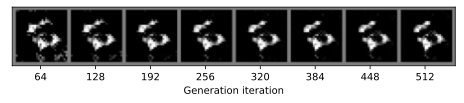

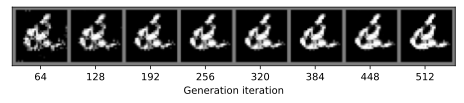

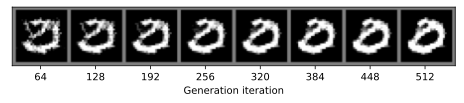

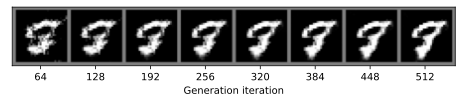

In [16]:
if USE_NOTEBOOK:
    for i in range(imgs_per_step.shape[1]):
        step_size = callback.num_steps // callback.vis_steps
        imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
        grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1,1), pad_value=0.5, padding=2)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(8,8))
        plt.imshow(grid)
        plt.xlabel("Generation iteration")
        plt.xticks([(imgs_per_step.shape[-1]+2)*(0.5+j) for j in range(callback.vis_steps)], 
                   labels=range(step_size,imgs_per_step.shape[0]+1,step_size))
        plt.yticks([])
        plt.show()

### Out-of-distribution detection

In [17]:
# np.random.binomial(128,0.05)

### Instability

## Conclusion